In [1]:
import numpy as np
import pandas as pd
import os
import glob
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show
from src.model.SimpleMILModels import Attention, MaxMIL, AttentionResNet
from src.dataloaders.DataLoaders import RetCCLFeatureLoader, RetCCLFeatureLoaderMem


import zarr
import seaborn as sns

recompute_attn = False

In [2]:
def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))

In [3]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [4]:
group = "BGUAJ0"

In [5]:

api = wandb.Api()


In [6]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": group})

# TCGA

Load in the tcga features for 50 random slides (not too much memory needed).

In [7]:
path_to_extracted_features = '/home/p163v/histopathology/TCGA/ffpe/299/'

In [8]:



slide_meta_tcga = pd.read_csv("../metadata/tcga_labeled_data.csv")

# 50 random slides

myx = np.random.choice(np.array(range(len(slide_meta_tcga[slide_meta_tcga.project=="GBM"].slide_id))), 50)

gbm_slides = slide_meta_tcga[slide_meta_tcga.project=="GBM"].slide_id.iloc[myx]

test_labels = slide_meta_tcga[slide_meta_tcga.project=="GBM"].labels.iloc[myx]

#all_files = [x for x in slide_annots.file if os.path.isfile(path_to_extracted_features + "/" + x)]
#    all_features = {file: h5py.File(path_to_extracted_features + "/" + file, 'r')['feats'][:] for file in all_files}

In [9]:
test_labels.mean()

0.68

In [10]:
test_features_tcga = [h5py.File(path_to_extracted_features + "/" + file + ".h5", 'r')['feats'][:] for file in gbm_slides]

We use the loss as the early stopping criteria


In [11]:
model_list = list()
attention_list = list()
prob_list = list()
pred_list = list()
cv =  lambda x: np.std(x) / np.mean(x)

In [12]:
test_data = RetCCLFeatureLoaderMem(test_features, np.array(test_labels), patches_per_iter='all')

RetCCLTest = DataLoader(test_data, batch_size=1, num_workers=1)#, sampler=valid_Sampler)


NameError: name 'test_features' is not defined

In [ ]:
for ii in range(len(runs)):
    
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version).split('-')[0]: a for a in arts}
    checkpoint_folder_name = arts_dict['model'].name.split('-')[1].removesuffix(':'+arts_dict['model'].version)
    args = runs[0].config

    model = Attention(2048, lr=args['lr'], weight_decay=args['weight_decay'], hidden_dim=args['hidden_dim'], attention_dim=args['attention_dim'], class_weights=torch.tensor(float(args['class_weights'])))
    chkpt_file = glob.glob('lightning_logs/'+checkpoint_folder_name+'/checkpoints/best_loss*')[0]
    model = model.load_from_checkpoint(chkpt_file, map_location=torch.device('cpu'))
    model.eval()
    model_list.append(model)
    model_forward = [model.forward(torch.tensor(x).to(model.device)) for x,y in iter(RetCCLTest)]
    model_attention = [x[2].detach().numpy() for x in model_forward]
    model_prob = [x[0].detach().numpy() for x in model_forward]
    model_pred = [x[1].detach().numpy() for x in model_forward]

    attention_list.append(model_attention)
    prob_list.append(model_prob)
    pred_list.append(model_pred)
    

In [60]:
prob_list = [np.concatenate(x) for x in prob_list]
pred_list = [np.concatenate(x) for x in pred_list]


In [69]:
prob_test = np.mean(np.vstack(prob_list), axis=0)

In [72]:
prob_test.shape

(49,)

In [73]:
np.array(test_labels).shape

(50,)

ValueError: Found input variables with inconsistent numbers of samples: [50, 49]

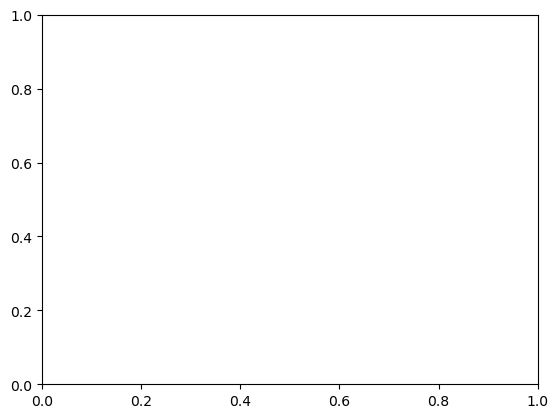

In [71]:


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    np.array(test_labels),
    np.mean(np.vstack(prob_list), axis=0),
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [72]:
cv_all = np.concatenate(testing_cv)
label_all = np.concatenate(testing_labels)
pred_all = np.concatenate(testing_preds)
prob_all = np.concatenate(testing_probs)
slides_all = np.concatenate(testing_slides)

In [107]:
attn_all = [x for y in testing_attn for x in y]

<Axes: ylabel='Count'>

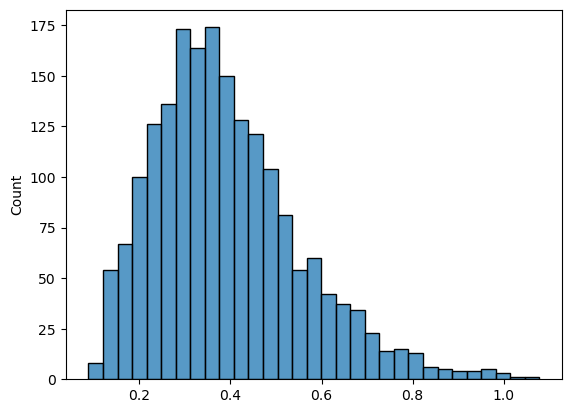

In [73]:
sns.histplot(cv_all)

In [110]:
slides_all[cv_all>1]

array([['902C256C-22E5-427E-9FAF-CAA206CE46C1'],
       ['F43222AB-5352-491B-9906-1100A046795D'],
       ['95C1EFE3-112A-48EF-A15C-F7A39AC13247']], dtype=object)

<Axes: ylabel='Count'>

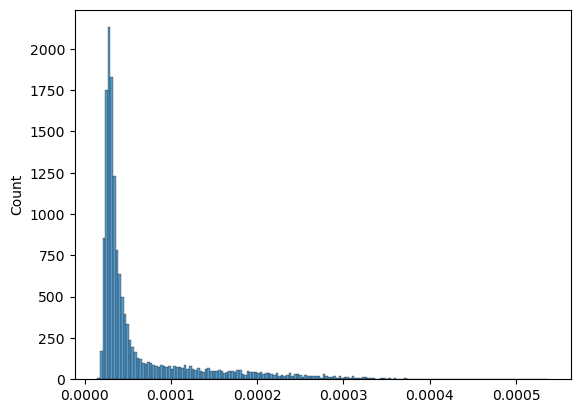

In [112]:
sns.histplot(attn_all[np.where(cv_all>1)[0][0]])

<Axes: ylabel='Count'>

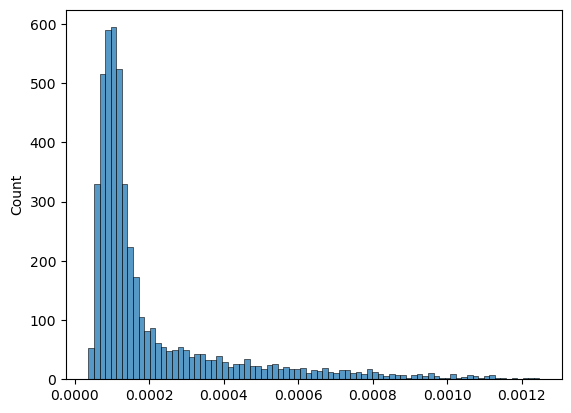

In [113]:
sns.histplot(attn_all[np.where(cv_all>1)[0][1]])

In [115]:
np.concatenate(testing_superfamily)[cv_all>1]

array(['Adult-type diffuse gliomas', 'Adult-type diffuse gliomas',
       'Paediatric-type diffuse high-grade gliomas'], dtype=object)

In [51]:
(label_all != pred_all.reshape(-1))[cv_all>1]

array([ True, False,  True])

Here is what to do next:
1. examine these slides manually
2. make their attentionmaps 
3. look at some cases of very little attn map heterogeneity
4. make meeting with Ramin
5. 


In [118]:
slides_all[cv_all<0.13]

array([['64F3A170-DF3D-46D7-828C-58C8C5979C88'],
       ['2133F66A-074E-4440-89F7-F0C288519066'],
       ['ABE01868-8E8A-49AC-995E-9834B819F27C'],
       ['36DA14C8-77AD-4574-B015-5CAAA7A8A6C8'],
       ['A566FA6E-052C-4206-AE32-0F7F6DE3EB8D'],
       ['0D6B7E38-D4EC-4D21-92B0-195E00990839'],
       ['D46198C6-C16E-4A8E-89A6-792E9937A27B'],
       ['DB0C22F7-BBB4-42E6-A4AB-476A9D9EEB97']], dtype=object)

In [120]:
np.concatenate(testing_superfamily)[cv_all<0.13]

array(['tumours of the sellar region', 'Adult-type diffuse gliomas',
       'Adult-type diffuse gliomas',
       'high-grade neuroepithelial tumour with MN1:BEND2 fusion',
       'Cranial and paraspinal nerve tumours',
       'tumours of the sellar region', 'Ependymal tumours',
       'Medulloblastoma', 'meningioma',
       'Cranial and paraspinal nerve tumours',
       'Cranial and paraspinal nerve tumours',
       'Cranial and paraspinal nerve tumours',
       'Cranial and paraspinal nerve tumours',
       'Low-grade glial/glioneuronal/neuroepithelial tumours',
       'Control tissues', 'Control tissues',
       'Low-grade glial/glioneuronal/neuroepithelial tumours',
       'Other CNS embryonal tumours'], dtype=object)

In [126]:
slides_all[cv_all<0.13][1:3]

array([['64F3A170-DF3D-46D7-828C-58C8C5979C88'],
       ['464F3236-0F1B-4DB0-A74B-92BA8A408630']], dtype=object)

In [121]:
(label_all != pred_all.reshape(-1))[cv_all<0.13]

array([ True,  True, False,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False])

<Axes: ylabel='Count'>

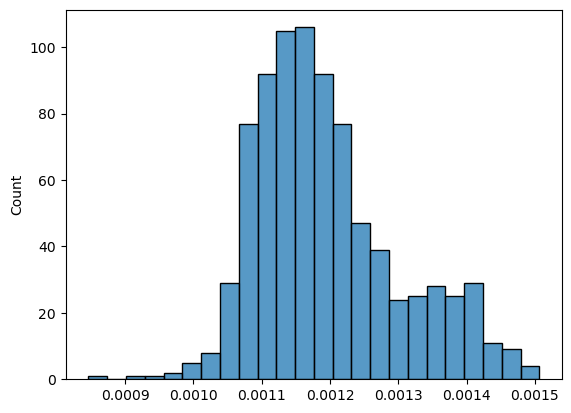

In [124]:
sns.histplot(attn_all[np.where(cv_all<0.13)[0][1]])

<Axes: ylabel='Count'>

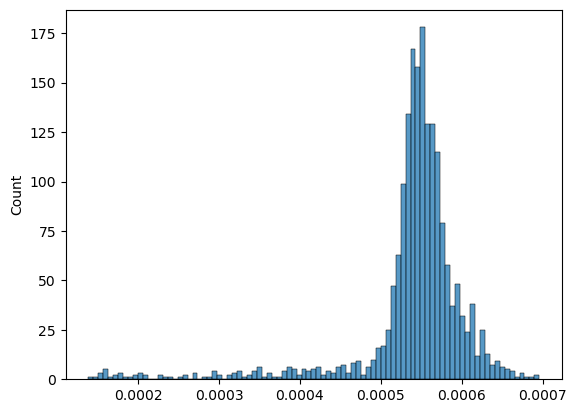

In [125]:
sns.histplot(attn_all[np.where(cv_all<0.13)[0][2]])

Now lets pick a confident correct and confident incorrect slide

In [129]:
is_glio = np.concatenate(testing_superfamily)=='Adult-type diffuse gliomas'

In [135]:
pred_all = pred_all.reshape(-1)

prob_all = prob_all.reshape(-1)

In [148]:
glio_probs = F.sigmoid(torch.tensor(prob_all[is_glio]))
glio_slides = slides_all[is_glio]
glio_tp = np.logical_and(pred_all[is_glio] == label_all[is_glio], label_all[is_glio]==True)
glio_fp = np.logical_and(pred_all[is_glio] != label_all[is_glio], label_all[is_glio]==True)
glio_tn = np.logical_and(pred_all[is_glio] == label_all[is_glio], label_all[is_glio]==False)
glio_fn = np.logical_and(pred_all[is_glio] != label_all[is_glio], label_all[is_glio]==False)

glio_slides[glio_tp][np.array(glio_probs[glio_tp]).argmax()]

array(['2F867856-C7A3-43BA-8A68-8934EB8AD5EA'], dtype=object)

In [149]:
glio_slides[glio_fp][np.array(glio_probs[glio_fp]).argmax()]

array(['46FE30DA-4585-45E6-AFB0-9B3AFDD34F13'], dtype=object)

In [150]:
glio_slides[glio_tn][np.array(glio_probs[glio_tn]).argmax()]

array(['0F5C2192-FD1D-4DF1-B232-485A83DCAFA9'], dtype=object)

In [151]:
glio_slides[glio_fn][np.array(glio_probs[glio_fn]).argmax()]

array(['A0792521-54D6-4EC8-9F45-B4FF197BFC81'], dtype=object)

In [33]:
np.mean((label_all != pred_all)[np.concatenate(testing_superfamily)=='Medulloblastoma'])


0.42986685766175964

Sanity Check:

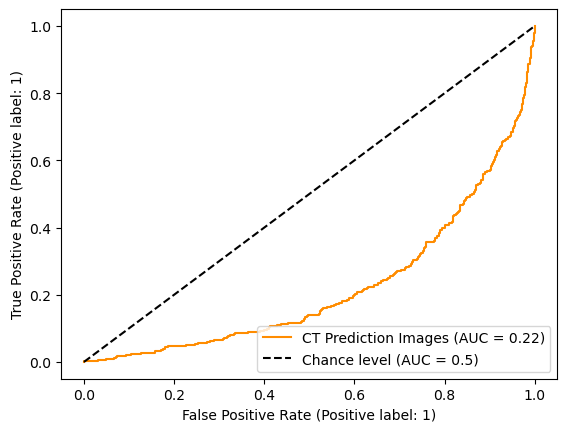

In [35]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    label_all,
    prob_all,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)

# UKHD


In [13]:
path_to_extracted_features = '/home/p163v/histopathology/UKHD_Neuro/RetCLL_Features/' 



slide_meta = pd.read_csv("../metadata/labels_with_new_batch.csv")
ct_scoring = pd.read_csv("../metadata/CT_3_Class_Draft.csv")

slide_meta_wbt = wandb.Table(dataframe=slide_meta)
ct_scoring_wbt = wandb.Table(dataframe=ct_scoring)

labels_artifact = wandb.Artifact("dataset_labels", type="labels")
labels_artifact.add(slide_meta_wbt, "slide_meta")
labels_artifact.add(ct_scoring_wbt, "ct_scoring")

ct_scoring["txt_idat"] = ct_scoring["idat"].astype("str")
ct_scoring.index = ct_scoring.txt_idat
slide_meta.index = slide_meta.idat
ct_scoring = ct_scoring.drop("txt_idat", axis=1)
slide_meta = slide_meta.drop("idat", axis=1)
slide_annots = slide_meta.join(ct_scoring, lsuffix="l")


slide_annots['file'] = slide_annots.uuid + ".h5"

slide_annots.index = slide_annots.uuid





In [14]:
myx = (slide_annots.max_super_family_class=='Adult-type diffuse gliomas') & (slide_annots.CT_class!='Unsure') & ([os.path.exists(path_to_extracted_features + "/" + file + ".h5") for file in slide_annots.uuid])


In [15]:
slide_annots.loc[myx]

,uuid,tumor_id,txt_LOKALISATION,num_ALTERSANGABE,patient_id,max_super_family_class,max_family_class,max_class,max_subclass,relevant Histo prediction,possible further consolidation,classifciation_v11,max_cal_v11,family,file_path,slide,Unnamed: 0,idat,CT_class,file
uuid,,,,,,,,,,,,,,,,,,,,
BB53705C-1CF8-456C-848D-5B4E372511B9,BB53705C-1CF8-456C-848D-5B4E372511B9,82436,rechts temporal,NaN,36642,Adult-type diffuse gliomas,"Glioblastoma, IDH-wildtype","glioblastoma, IDH-wildtype, mesenchymal type","Glioblastoma, IDH-wildtype, [typical mesenchym...","glioblastoma, IDH-wildtype, mesenchymal type","glioblastoma, IDH-wildtype","methylation class glioblastoma, IDH wildtype, ...",0.986505,glioblastoma,/omics/odcf/analysis/OE0606_projects/pancancer...,BB53705C-1CF8-456C-848D-5B4E372511B9,1136.0,101231000009_R04C01,No Chromothripsis,BB53705C-1CF8-456C-848D-5B4E372511B9.h5
E7B93080-1B3C-408C-9B82-9B0D25E68B1F,E7B93080-1B3C-408C-9B82-9B0D25E68B1F,82438,"supratentoriell, links temporal",NaN,36643,Adult-type diffuse gliomas,"Glioblastoma, IDH-wildtype","glioblastoma, IDH-wildtype, mesenchymal type","Glioblastoma, IDH-wildtype, [typical mesenchym...","glioblastoma, IDH-wildtype, mesenchymal type","glioblastoma, IDH-wildtype","methylation class glioblastoma, IDH wildtype, ...",0.433829,glioblastoma,/omics/odcf/analysis/OE0606_projects/pancancer...,E7B93080-1B3C-408C-9B82-9B0D25E68B1F,1138.0,101231000009_R05C01,Chromothripsis,E7B93080-1B3C-408C-9B82-9B0D25E68B1F.h5
C8CE0A14-161B-4654-9C8B-26E1E46FDD15,C8CE0A14-161B-4654-9C8B-26E1E46FDD15,82538,k. A.,43.0,36679,Adult-type diffuse gliomas,"diffuse glioma, IDH mutant","diffuse glioma, IDH-mutant and 1p19q retained ...","Astrocytoma, IDH-mutant; lower grade","Astrocytoma, IDH-mutant; lower grade","Astrocytoma, IDH-mutant","methylation class IDH glioma, subclass astrocy...",0.964166,astrocytoma,/omics/odcf/analysis/OE0606_projects/pancancer...,C8CE0A14-161B-4654-9C8B-26E1E46FDD15,1149.0,101231000014_R04C02,No Chromothripsis,C8CE0A14-161B-4654-9C8B-26E1E46FDD15.h5
A774D3B3-AE20-4531-B1DA-BFE9982DD86F,A774D3B3-AE20-4531-B1DA-BFE9982DD86F,82698,supratentoriell,40.0,36747,Adult-type diffuse gliomas,"Glioblastoma, IDH-wildtype","glioblastoma, IDH-wildtype, mesenchymal type","Glioblastoma, IDH-wildtype, [typical mesenchym...","glioblastoma, IDH-wildtype, mesenchymal type","glioblastoma, IDH-wildtype","methylation class glioblastoma, IDH wildtype, ...",0.915389,glioblastoma,/omics/odcf/analysis/OE0606_projects/pancancer...,A774D3B3-AE20-4531-B1DA-BFE9982DD86F,1193.0,101231000034_R04C02,Chromothripsis,A774D3B3-AE20-4531-B1DA-BFE9982DD86F.h5
07A87F90-DC34-4DA7-9D01-54CDF62B0331,07A87F90-DC34-4DA7-9D01-54CDF62B0331,83246,"supratentoriell, temporal links",25.0,27562,Adult-type diffuse gliomas,"diffuse glioma, IDH mutant","diffuse glioma, IDH-mutant and 1p19q retained ...","Astrocytoma, IDH-mutant; lower grade","Astrocytoma, IDH-mutant; lower grade","Astrocytoma, IDH-mutant","methylation class IDH glioma, subclass astrocy...",0.968453,astrocytoma,NaN,07A87F90-DC34-4DA7-9D01-54CDF62B0331,2125.0,200091640007_R04C01,No Chromothripsis,07A87F90-DC34-4DA7-9D01-54CDF62B0331.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2F343AC0-FF83-46BB-BC13-BA2962DB9FAE,2F343AC0-FF83-46BB-BC13-BA2962DB9FAE,70646,"supratentoriell, temporal rechts",68.0,4236,Adult-type diffuse gliomas,"Glioblastoma, IDH-wildtype","glioblastoma, IDH-wildtype, mesenchymal type","Glioblastoma, IDH-wildtype, [typical mesenchym...","glioblastoma, IDH-wildtype, mesenchymal type","glioblastoma, IDH-wildtype","methylation class glioblastoma, IDH wildtype, ...",0.353740,glioblastoma,/omics/odcf/analysis/OE0606_projects/pancancer...,2F343AC0-FF83-46BB-BC13-BA2962DB9FAE,124240.0,9969477088_R04C02,No Chromothripsis,2F343AC0-FF83-46BB-BC13-BA2962DB9FAE.h5
F658F54F-4E2B-41F3-91B6-12B2C7D54FC2,F658F54F-4E2B-41F3-91B6-12B2C7D54FC2,70806,"supratentoriell, temporal links",34.0,4283,Adult-type diffuse gliomas,"Glioblastoma, IDH-wil

In [16]:
test_features_ukhd = [h5py.File(path_to_extracted_features + "/" + file + ".h5", 'r')['feats'][:] for file in slide_annots.loc[myx].uuid]

In [17]:
import umap

/home/p163v/mambaforge/envs/marugoto/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/p163v/mambaforge/envs/marugoto/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/p163v/mambaforge/envs/marugoto/lib/python3.9/site-packages/uma

In [18]:
ukhd_concat = np.concatenate(test_features_ukhd[0:10],axis=0)

In [19]:
tcga_concat = np.concatenate(test_features_tcga[0:10],axis=0)

In [20]:
all_concat = np.concatenate([tcga_concat, ukhd_concat],axis=0)

In [21]:
embedding = umap.UMAP(n_neighbors=50,
                      metric='correlation').fit_transform(all_concat)

KeyboardInterrupt: 

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[x for x in patids])